Imports

In [1]:
import pathlib
import os
import numpy as np
import torch
from torch import optim
from subgraph_matching_via_nn.data.data_loaders import load_graph
from powerful_gnns.util import S2VGraph
from powerful_gnns.util import load_data_given_graph_list_and_label_map
from powerful_gnns.models.graphcnn import GraphCNN
from powerful_gnns.util import separate_data
from powerful_gnns.classifier_training import train, test
from common.EmbeddingCalculationsService import pairwise_l2_distance, show_distance_matrix, \
    calculate_energy_based_hidden_rep
from subgraph_matching_via_nn.training.PairSampleInfo import Pair_Sample_Info
from subgraph_matching_via_nn.data.annotated_graph import AnnotatedGraph
from subgraph_matching_via_nn.graph_metric_networks.graph_metric_nn import MLPGraphMetricNetwork
from subgraph_matching_via_nn.graph_metric_networks.embedding_metric_nn import EmbeddingMetricNetwork
from subgraph_matching_via_nn.graph_embedding_networks.gnn_embedding_network import GNNEmbeddingNetwork
from subgraph_matching_via_nn.training.trainer.S2VGraphEmbeddingSimilarityMetricTrainer import \
    S2VGraphEmbeddingSimilarityMetricTrainer
from subgraph_matching_via_nn.graph_metric_networks.graph_metric_nn import SingleEmbeddingGraphMetricNetwork
from subgraph_matching_via_nn.graph_metric_networks.graph_metric_nn import S2VGraphEmbeddingGraphMetricNetwork
from networkx import NetworkXError
import itertools
from livelossplot import PlotLosses
import networkx as nx

In [2]:
goal_subcircuit_name = 'alu'
DATA_PATH = 'C:/Users/kogan/OneDrive/Desktop/Research/AMIT/GraphMatching/subgraph_matching_via_nn/data/subcircuits/'
desktop = pathlib.Path(DATA_PATH)
subgraphs = []
labels = []
for circuit_dir in desktop.iterdir():
    if circuit_dir.is_dir():
        for subcircuit_file in circuit_dir.iterdir():
            if subcircuit_file.is_file():
                file_name = subcircuit_file.name
                if file_name == 'full_graph.p':
                    file_rel_path = f"{os.sep}{file_name}"
                    loader_params = {
                     'data_path' : str(circuit_dir),
                     'g_full_path': file_rel_path,
                     'g_sub_path': file_rel_path}

                    sub_graph = \
                        load_graph(type='subcircuit',
                                   loader_params=loader_params)

                    if goal_subcircuit_name in circuit_dir.name:
                        labels.append(1)
                    else:
                        # continue #TODO?
                        labels.append(0)
                    subgraphs.append(sub_graph)

labels = np.array(labels, dtype='float32')
N = len(subgraphs)
N_training = int(2 / 3 * N)

In [3]:
subgraphs = []
labels = []

circuit_base_dir = 'C:\\Users\\kogan\\OneDrive\\Desktop\\Research\\AMIT\\GraphMatching\\subgraph_matching_via_nn\\data\\subcircuits\\'
for circuit_file_name in ['adder_4', 'alu_4', 'alu_8', 'alu_16', 'alu_32', 'mul_4_4', 'mul_4_8', 'mul_8_8', 'mul_16_16', 'mul_16_32']:
    file_rel_path = 'full_graph.p'
    circuit_dir = f"{circuit_base_dir}{circuit_file_name}{os.sep}"
    loader_params = {
     'data_path' : str(circuit_dir),
     'g_full_path': file_rel_path,
     'g_sub_path': file_rel_path}

    sub_graph = \
        load_graph(type='subcircuit',
                   loader_params=loader_params)
    subgraphs.append(sub_graph)
    labels.append(0)
labels[0] = 1

N = len(subgraphs)
N_training = int(2 / 3 * N)

Transform graphs into S2VGraph-s

In [4]:
g_list = []
label_dict = {}
for subgraph, label in zip(subgraphs, labels):
    g_list.append(S2VGraph(subgraph.G, label))

    if not label in label_dict:
        mapped = len(label_dict)
        label_dict[label] = mapped

Process graph features

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

graphs, num_classes = load_data_given_graph_list_and_label_map(g_list, label_dict, degree_as_tag=True, device=device)

# classes: 2
# maximum node tag: 48
# data: 10


Setup model and training

In [6]:
#set up seeds and gpu device
torch.manual_seed(0)
np.random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

##k-fold cross validation. Conduct an experiment on the fold specified by args.fold_idx.
# train_graphs, test_graphs = separate_data(graphs, seed=0, fold_idx=0, n_splits=1)
# train_graphs = graphs[:4]
# test_graphs = graphs[4:]
train_graphs = test_graphs = graphs

model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=train_graphs[0].node_features.shape[1], hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

Train and Test

In [7]:
liveloss = PlotLosses(mode='notebook')

filename = ""
epochs = 3
k_update_plot = 25

for epoch in range(1, epochs + 1):
    scheduler.step()

    avg_loss = train(iters_per_epoch=50, batch_size=len(train_graphs), model=model, device=device, train_graphs=train_graphs, optimizer=optimizer, epoch=epoch)
    acc_train, acc_test = test(model, device, train_graphs, test_graphs, epoch)

    if not filename == "":
        with open(filename, 'w') as f:
            f.write("%f %f %f" % (avg_loss, acc_train, acc_test))
            f.write("\n")
    print("")

    print(model.eps)

    if epoch % k_update_plot == 0:
        liveloss.update({'train error': avg_loss.item()})
        liveloss.send()

c:\users\kogan\.virtualenvs\subcircuit_recognition-mmb-fima\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
epoch: 1: 100%|██████████| 50/50 [00:02<00:00, 18.98batch/s]


loss training: 1.255096
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0., 0., 0., 0.], device='cuda:0', requires_grad=True)


epoch: 2: 100%|██████████| 50/50 [00:01<00:00, 43.24batch/s]


loss training: 0.113457
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0., 0., 0., 0.], device='cuda:0', requires_grad=True)


epoch: 3: 100%|██████████| 50/50 [00:01<00:00, 43.38batch/s]

loss training: 0.274114
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0., 0., 0., 0.], device='cuda:0', requires_grad=True)


Show predictions

In [8]:
pred = model(train_graphs).max(1, keepdim=True)[1]
print(pred)

tensor([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')


In [9]:
pred = model(test_graphs).max(1, keepdim=True)[1]
print(pred)

tensor([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')


show all distances matrix (margin)

In [10]:
all_embeddings = model.get_embedding(graphs)

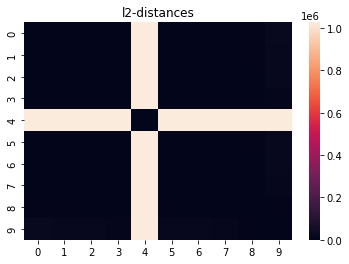

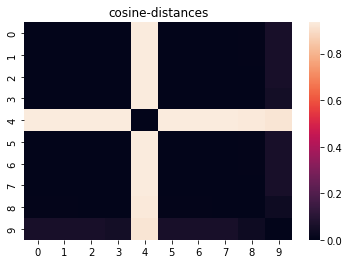

In [11]:
l2_dists = pairwise_l2_distance(all_embeddings)

rounding_constant = 10 ** 3
cos_dists = torch.round(calculate_energy_based_hidden_rep(all_embeddings, threshold=-1) * rounding_constant) / rounding_constant

show_distance_matrix(l2_dists, "l2-distances")
show_distance_matrix(cos_dists, "cosine-distances")

what is the smallest margin?

In [12]:
def get_min_non_diagonal_entry(tensor_):
    tensor_with_inf_diag = tensor_ + torch.diag_embed(torch.ones(tensor_.shape[0], device=device) * float("inf"))
    return torch.min(tensor_with_inf_diag).item()

print(get_min_non_diagonal_entry(l2_dists))
print(get_min_non_diagonal_entry(cos_dists))

0.00036881212145090103
0.0


Contrastive loss training

Assemble graph pairs data

In [13]:
train_samples_list = []
reference_subgraph_index = 0
reference_subgraph = subgraphs[reference_subgraph_index]
negative_examples_subgraphs = subgraphs[1:]

for subgraph in subgraphs:
    if subgraph == reference_subgraph:
        is_negative_example = False
    else:
        is_negative_example = True

    G1_annotated = AnnotatedGraph(subgraph.G)
    G2_annotated = AnnotatedGraph(reference_subgraph.G)
    train_samples_list.append(Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example)))

val_samples_list = train_samples_list

Define GNN model

In [14]:
# input dim matches the node mask (w) shape
input_dim = S2VGraphEmbeddingSimilarityMetricTrainer.get_model_expected_input_dim(train_samples_list[0])
model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device).to(device)

Define graph metric to train, and the trainer

In [15]:
solver_params = {
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "lr": 1e-3, "weight_decay": 1e-3,
    "max_epochs": 10000,
    "cycle_patience": 5, "step_size_up": 10, "step_size_down": 10,
    "loss_convergence_threshold": None,
    "train_loss_convergence_threshold": 1e-3,
    "successive_convergence_min_iterations_amount": 5,
    "margin_loss_margin_value": 5,
    "max_grad_norm": 0.1,
    "k_update_plot": 50,
    "batch_size": len(subgraphs),
}

problem_params = {"input_dim": input_dim}

dump_base_path = f".{os.sep}runlogs"

def init_embedding_net_and_trainer(model):

    loss_fun = torch.nn.MSELoss()
    embedding_metric_network = EmbeddingMetricNetwork(loss_fun=loss_fun)

    gnn_embedding_nn = GNNEmbeddingNetwork(gnn_model=model)

    # embedding_nns = \
    #     [
    #         GNNEmbeddingNetwork(gnn_model=model),
    #     ]

    graph_metric_nn = S2VGraphEmbeddingGraphMetricNetwork(embedding_network=gnn_embedding_nn,
                                           embdding_metric_network=embedding_metric_network,
                                           device=device)

    # graph_metric_nn = SingleEmbeddingGraphMetricNetwork(embedding_network=embedding_nns[0],
    #                                        embdding_metric_network=embedding_metric_network,
    #                                        device=device)

    # graph_metric_nn = MLPGraphMetricNetwork(embedding_networks=embedding_nns,
    #                                         embdding_metric_network=embedding_metric_network,
    #                                         device=device)


    trainer = S2VGraphEmbeddingSimilarityMetricTrainer(graph_metric_nn, dump_base_path,
                                      problem_params, solver_params)

    return trainer, graph_metric_nn

trainer, graph_metric_nn = init_embedding_net_and_trainer(model)

Train

In [16]:
trainer.train(train_samples_list, val_samples_list)

dump path: .\runlogs\1700744300.8239732


c:\users\kogan\.virtualenvs\subcircuit_recognition-mmb-fima\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


([15.814776420593262,
  15.814776420593262,
  13.138988494873047,
  11.581352233886719,
  7.104454517364502,
  4.563517093658447,
  2.5711960792541504,
  3.0072338581085205,
  9.999999717180685e-10,
  0.1572018414735794,
  0.11242615431547165,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10],
 [15.814776420593262,
  13.138988494873047,
  11.581352233886719,
  7.104454517364502,
  4.563517093658447,
  2.5711960792541504,
  3.0072338581085205,
  9.999999717180685e-10,
  0.1572018414735794,
  0.11242615431547165,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10])

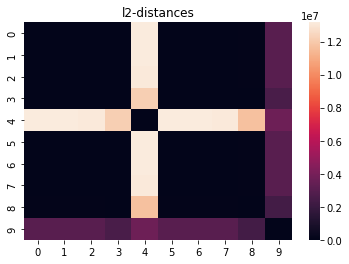

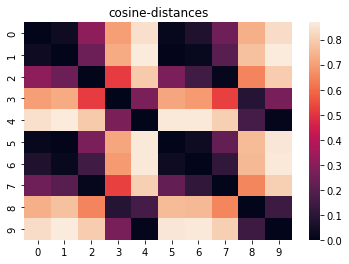

Off matrix diagonal margin: 9.627640724182129
Off matrix diagonal margin: 0.006000000052154064


In [17]:
def show_distances_heatmap(graphs, model):

    model.eval()
    all_embeddings = model.get_embedding(graphs)

    l2_dists = pairwise_l2_distance(all_embeddings)

    rounding_constant = 10 ** 3
    cos_dists = torch.round(calculate_energy_based_hidden_rep(all_embeddings, threshold=-1) * rounding_constant) / rounding_constant

    show_distance_matrix(l2_dists, "l2-distances")
    show_distance_matrix(cos_dists, "cosine-distances")
    print(f"Off matrix diagonal margin: {get_min_non_diagonal_entry(l2_dists)}")
    print(f"Off matrix diagonal margin: {get_min_non_diagonal_entry(cos_dists)}")

show_distances_heatmap(graphs, model)

Add ged=1 examples as positive examples

In [18]:
def generate_perturbed_graphs(reference_graph: nx.Graph):
    # assumption: there are no self loops, and no duplicate edges of opposite directions

    # graphs generated by removing an existing edge
    for edge in reference_graph.edges:
        copy_graph = reference_graph.copy()
        copy_graph.remove_edge(*edge)
        yield copy_graph

    # graphs generated by adding a missing edge
    sorted_nodes = sorted(reference_graph.nodes, reverse=False)
    for i, node_i in enumerate(sorted_nodes):
        if i == len(sorted_nodes) - 1:
            break

        for node_j in sorted_nodes[i+1:]:
            edge = (node_i, node_j)
            if reference_graph.has_edge(*edge):
                continue
            copy_graph = reference_graph.copy()
            copy_graph.add_edge(*edge)
            yield copy_graph

# generate subgraphs for which ged(subgraph, reference_subgraph)==1
perturbed_graphs = list(generate_perturbed_graphs(reference_subgraph.G_sub))
for perturbed_graph in perturbed_graphs:
    is_negative_example = False

    G1_annotated = AnnotatedGraph(perturbed_graph)
    G2_annotated = AnnotatedGraph(reference_subgraph.G)
    train_samples_list.append(Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example)))

In [19]:
len(train_samples_list)

101

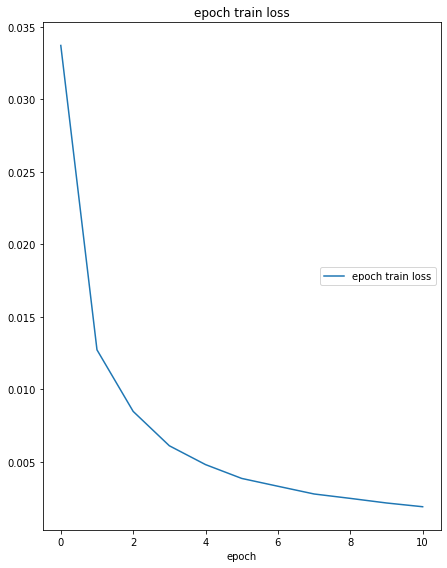

epoch train loss
	epoch train loss 	 (min:    0.002, max:    0.034, cur:    0.002)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\kogan\.virtualenvs\subcircuit_recognition-mmb-fima\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\kogan\AppData\Local\Temp/ipykernel_784/3134415617.py", line 7, in <module>
    trainer.train(train_samples_list, val_samples_list)
  File "C:\Users\kogan\OneDrive\Desktop\Research\AMIT\GraphMatching\subgraph_matching_via_nn\training\trainer\SimilarityMetricTrainerBase.py", line 156, in train
    return self._train_loop(self.graph_similarity_module, train_loader, val_loader,
  File "C:\Users\kogan\OneDrive\Desktop\Research\AMIT\GraphMatching\subgraph_matching_via_nn\training\trainer\SimilarityMetricTrainerBase.py", line 190, in _train_loop
    train_loss = self.calculate_loss_for_batch(train_batch, is_train=True)
  File "C:\Users\kogan\OneDrive\Desktop\Research\AMIT\GraphMatching\subgraph_matching_via_nn\training\trainer\SimilarityMetricTrai

TypeError: object of type 'NoneType' has no len()

In [19]:
val_samples_list = train_samples_list
model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device).to(device)
solver_params["batch_size"] = len(train_samples_list)

trainer, graph_metric_nn = init_embedding_net_and_trainer(model)

trainer.train(train_samples_list, val_samples_list)

In [20]:
def generate_s2v_graphs(networkx_graphs, print_stats=True):
    g_list = []
    label_dict = {}
    for networkx_graph in networkx_graphs:
        g_list.append(S2VGraph(networkx_graph, label=None))

        if not label in label_dict:
            mapped = len(label_dict)
            label_dict[label] = mapped

    graphs, _ = load_data_given_graph_list_and_label_map(g_list, label_dict, degree_as_tag=True, device=device, print_stats=print_stats)
    for s2v_graph in graphs:
        # convert graph features here, not only in trainer! (heatmap is probably wrong)
        annotated_graph = AnnotatedGraph(s2v_graph.g)
        s2v_graph.node_features = annotated_graph.node_indicator.to(device=device)

    return graphs

ERROR! Session/line number was not unique in database. History logging moved to new session 1205


# classes: 1
# maximum node tag: 49
# data: 101


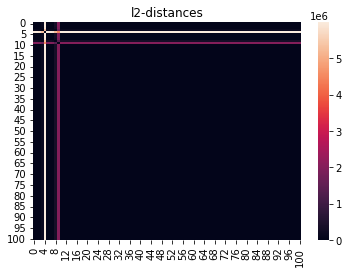

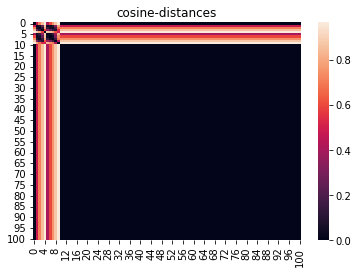

Off matrix diagonal margin: 9.237055564881302e-14
Off matrix diagonal margin: 0.0


In [21]:
all_s2v_graphs = generate_s2v_graphs([subgraph.G for subgraph in subgraphs] + perturbed_graphs)
show_distances_heatmap(all_s2v_graphs, model)

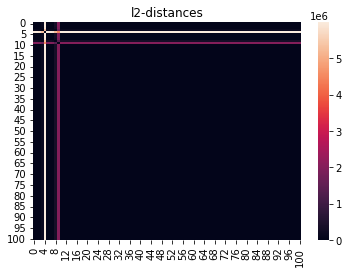

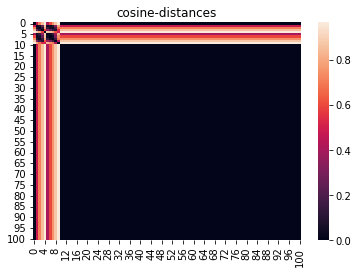

Off matrix diagonal margin: 9.237055564881302e-14
Off matrix diagonal margin: 0.0


In [22]:
show_distances_heatmap(all_s2v_graphs, model)

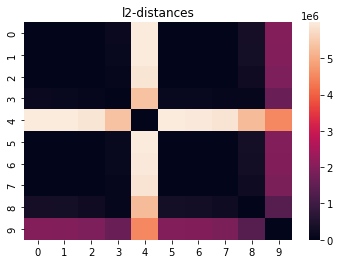

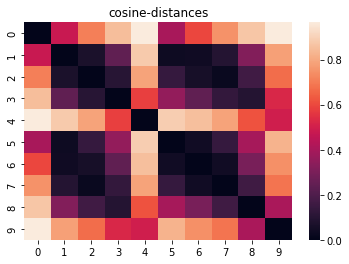

Off matrix diagonal margin: 53.48467254638672
Off matrix diagonal margin: 0.024000000208616257


In [23]:
show_distances_heatmap(all_s2v_graphs[:len(subgraphs)], model)

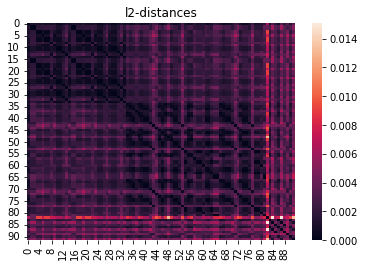

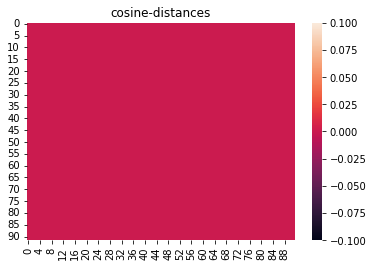

Off matrix diagonal margin: 9.237055564881302e-14
Off matrix diagonal margin: 0.0


In [24]:
reference_s2v_graph = all_s2v_graphs[reference_subgraph_index]
reference_graph_with_positive_examples = [reference_s2v_graph] + all_s2v_graphs[len(subgraphs):]
reference_graph_with_negative_examples = [all_s2v_graphs[i] for i in range(len(all_s2v_graphs[:len(subgraphs)])) if i != reference_subgraph_index]

show_distances_heatmap(reference_graph_with_positive_examples, model)

In [25]:
all_embeddings = model.get_embedding(reference_graph_with_positive_examples)
l2_dists = pairwise_l2_distance(all_embeddings)

In [26]:
model.eval()

GraphCNN(
  (mlps): ModuleList(
    (0): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (batch_norms): ModuleList(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (batch_norms): ModuleList(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (batch_norms): ModuleList(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): MLP

In [27]:
positive_distances = []
for positive_example_second_graph in reference_graph_with_positive_examples:
    distance = graph_metric_nn.forward([(reference_s2v_graph, positive_example_second_graph)]).item()
    positive_distances.append(distance)
    if distance > solver_params['margin_loss_margin_value']:
        print(f"positive loss term not zero, as distance for this positive example pair is {distance}")

negative_distances = []
for negative_example_second_graph in reference_graph_with_negative_examples:
    distance = graph_metric_nn.forward([(reference_s2v_graph, negative_example_second_graph)]).item()
    negative_distances.append(distance)
    if distance < solver_params['margin_loss_margin_value']:
        print(f"negative loss term not zero, as distance for this negative example pair is {distance}")

In [28]:
max(positive_distances)

9.557831072015688e-05

In [29]:
min(negative_distances)

6.515549659729004

k-subgraphs experiment

In [39]:
def generate_pair_example(G1_annotated, G2_annotated, is_negative_example):
    return Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example))

def compare_graphs_and_generate_pair_example(G1_annotated, G2_annotated):
    SG1 = G1_annotated.g
    SG2 = G2_annotated.g
    try:
        diff_graph = nx.difference(SG1, SG2)
    except NetworkXError:
        # node sets are different
        if nx.is_empty(SG1) and nx.is_empty(SG2) and (len(SG1) == len(SG2)):
            # positive example
            return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = False)
        else:
            # negative example
            return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = True)

    if nx.is_empty(diff_graph):
        print("isomorphic graphs")
        # positive example
        return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = False)
    else:
        # negative example
        return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = True)

K = 11
full_graph = reference_subgraph.G

subgraphs_iterator = itertools.combinations(full_graph, K)
k_subgraphs = [full_graph.subgraph(s) for s in subgraphs_iterator]
k_subgraph_annotated_graphs = [AnnotatedGraph(g) for g in k_subgraphs]

train_samples_list = []

In [42]:
for subgraph_counter1, SG_annotated_1 in enumerate(k_subgraph_annotated_graphs):
    for subgraph_counter2 in range(subgraph_counter1+1, len(k_subgraph_annotated_graphs)):
        SG_annotated_2 = k_subgraph_annotated_graphs[subgraph_counter2]
        train_samples_list.append(compare_graphs_and_generate_pair_example(SG_annotated_1, SG_annotated_2))


isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic graphs
isomorphic

In [ ]:

# k_subgraph_to_perturbed_graphs_map = {}
#
# #TODO: some problem with the space, as SG1 can be non isomorphic to SG2_perturbed, but SG2_perturbed can be a perturbation of SG1, no?
#
# # generate subgraphs for which GED==1
# for subgraph_counter1, SG1 in enumerate(k_subgraphs):
#     perturbed_graphs = list(generate_perturbed_graphs(SG1))
#     for perturbed_graph in perturbed_graphs:
#         # positive example
#         train_samples_list.append(generate_pair_example(SG1, perturbed_graph, is_negative_example = False))
#     k_subgraph_to_perturbed_graphs_map[SG1] = perturbed_graphs
#
# # generate all pairs examples
# for SG1, SG1_perturbed_graphs in k_subgraph_to_perturbed_graphs_map.items():
#     for SG2, SG2_perturbed_graphs in k_subgraph_to_perturbed_graphs_map.items():
#
#         if SG1 == SG2:
#             continue # trivial pairs, or pairs already considered
#
#         for SG2_perturbed_graph in SG2_perturbed_graphs:
#             train_samples_list.append(compare_graphs_and_generate_pair_example(SG1, SG2_perturbed_graph))
#
#         for SG1_perturbed_graph in SG1_perturbed_graphs:
#             train_samples_list.append(compare_graphs_and_generate_pair_example(SG1_perturbed_graph, SG2))

In [43]:
for k_subgraph in k_subgraphs:
    if k_subgraphs[0].nodes == k_subgraph.nodes:
        print("yes")


yes


In [44]:
len(k_subgraphs)

364

In [45]:
len(train_samples_list)

66066

In [51]:
train_samples_list = train_samples_list[:10000]

In [52]:
# disable debugging overhead operations
torch.autograd.set_detect_anomaly(mode=False)

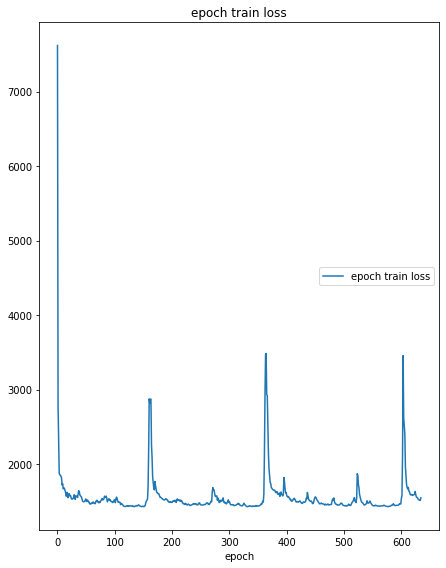

epoch train loss
	epoch train loss 	 (min: 1427.182, max: 7619.519, cur: 1547.862)


KeyboardInterrupt: 

In [57]:
val_samples_list = train_samples_list
model = GraphCNN(num_layers=7, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=128, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device).to(device)
solver_params["batch_size"] = 512 # 4096#2048 #1024 #512
solver_params["k_update_plot"] = 1
solver_params["lr"] = 1e-3
trainer, graph_metric_nn = init_embedding_net_and_trainer(model)

trainer.train(train_samples_list, val_samples_list)

In [ ]:
for i in range(0, 10000):
    is_negative_sample = train_samples_list[i].is_negative_sample
    graph1 = train_samples_list[i].subgraph
    graph2 = train_samples_list[i].masked_graph

    s2v_graphs = generate_s2v_graphs([graph1.g, graph2.g], print_stats=False)

    distance = graph_metric_nn.forward([(s2v_graphs[0], s2v_graphs[1])]).item()

    if is_negative_sample and (distance < solver_params['margin_loss_margin_value']):
        print(f"negative loss term not zero, as distance for this negative example pair is {distance}")
    if (not is_negative_sample) and (distance > solver_params['margin_loss_margin_value']):
        print(f"negative loss term not zero, as distance for this positive example pair is {distance}")